<a href="https://colab.research.google.com/github/ribesstefano/ml4justice-feature-predictor/blob/main/notebooks/ml4justice_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# !pip install lightning -qqq

In [11]:
import pandas as pd

base_dir = "../data/processed/"
dataset_df = pd.read_csv(base_dir + 'dataset-sentenze-omicidio-stradale-with-summaries-translated.csv', encoding='utf-8')

dataset_df = dataset_df.drop_duplicates(subset=['raw text'])

# Fix an empy 'facts' column...
dataset_df['facts'] = dataset_df.apply(lambda x: x['facts'] if pd.notna(x['facts']) else x['raw text'], axis=1)
dataset_df[dataset_df['facts'].isna()]

print(len(dataset_df))

In [12]:
label_columns = dataset_df.iloc[:, 2:46].columns.tolist()
id2label = {i: l for i, l in enumerate(label_columns)}
label2id = {v: k for k, v in id2label.items()}
# id2label

## PyTorch Dataset

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vectorizer=None, precomputed_features=False):
        self.precomputed_features = precomputed_features
        if precomputed_features:
            self.features = texts
        else:
            if vectorizer:
                self.vectorizer = vectorizer
                self.features = self.vectorizer.transform(texts)
            else:
                self.vectorizer = CountVectorizer(
                    ngram_range=(1, 2),  # For example, unigrams and bigrams
                    stop_words=['italian'],
                    binary=True,
                    decode_error='ignore',
                )
                self.features = self.vectorizer.fit_transform(texts)
        self.labels = labels
        if self.features.shape[0] != len(self.labels):
            raise ValueError(
                f"Number of samples in features ({self.features.shape[0]}) "
                f"and labels ({len(self.labels)}) do not match."
            )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.precomputed_features:
            return {
                'X': torch.tensor(self.features[idx]).squeeze().float(),
                'y': torch.tensor(self.labels.iloc[idx]).float(),
            }
        else:
            return {
                'X': torch.tensor(self.features[idx].toarray()).squeeze().float(),
                'y': torch.tensor(self.labels.iloc[idx]).float(),
            }

# Data Preparation
texts = dataset_df['raw text']
labels = dataset_df.iloc[:, 2:46]  # Adjust indices as needed
dataset = TextDataset(texts, labels)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
# dataset[0]
batch = next(iter(train_loader))
print(batch['X'].size())
print(batch['y'].size())

### Data Balance

SMOTE is not supported for multilabel classification. We will use a custom sampler to balance the dataset.

In [14]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(vectors, dataset_df.iloc[:, 2:46])

TODO: An idea would be to translate back and forth the text in order to generate variations. Still a work in progress.

In [22]:
# !pip install deep-translator -qqq

import textwrap
from deep_translator import GoogleTranslator

translator_it2zh = GoogleTranslator(source='it', target='zh-CN')
translator_zh2it = GoogleTranslator(source='zh-CN', target='it')

def translate_back_and_forth(text, translator1=translator_it2zh, translator2=translator_zh2it):
    return translator2.translate(translator1.translate(text)[:4999])

test_it = "All'imputato era stata contestata una colpa generica e la violazione dell'art. 141 C.d.S. poiché alla guida della sua autovettura, nel percorrere la strada provinciale n. (Omissis), alla guida dell'autocarro (Omissis), aveva tenuto una velocità non adeguata e comunque pari a 80 Km/h non commisurata allo stato dei luoghi,in considerazione delle condizioni metereologiche e dell'ora serale, e, affrontando un tratto di strada curvilineo, aveva perso il controllo del veicolo che, capovolgendosi, rovinava contro un manufatto, così cagionando la morte per gravissimo trauma cranico del F.C., seduto al lato passeggero anteriore.  La Corte territoriale, nel respingere i motivi di gravame, riteneva esaustiva la motivazione della sentenza di prime cure in ordine alle modalità del sinistro, su cui si soffermava rispondendo alle osservazioni mosse dall'appellante; confermava la statuizione del primo giudice in ordine al mancato riconoscimento delle circostanze attenuanti generiche, la durata della sanzione amministrativa accessoria e l'ammontare delle spese liquidate dal Tribunale in favore delle parti civili.  2. Avverso tale pronuncia ha proposto ricorso l'imputato, a mezzo del difensore di fiducia, per tre distinti motivi.  2.1. Con un primo motivo lamenta vizio di mancanza della motivazione in ordine alla ricostruzione della dinamica del sinistro, non essendo illustrate le ragioni per cui la Corte territoriale aveva deciso di disattendere le risultanze della consulenza tecnica di parte, puntualmente illustrate negli specifici motivi di appello.  La sentenza impugnata risultava priva dei passaggi logici ed argomentativi indispensabili, essendosi limitata al mero richiamo delle considerazioni svolte dal giudice di primo grado, tacendo del tutto le ragioni per le quali erano stati ritenuti inattendibili le fonti di prova a discarico dell'imputato. "
print(textwrap.fill(test_it, 150))
print('-' * 150)
print(textwrap.fill(translate_back_and_forth(test_it + test_it), 150))
print('-' * 150)

In [16]:
translate_back_and_forth(test_it + test_it)

"L'imputato è stato accusato di negligenza grave e violazione dell'art. 141 C.d.S. perché stava percorrendo una strada provinciale. Il conducente del camion (Omissis) ha mantenuto una velocità inadeguata, comunque pari a 80 km/h, sproporzionata rispetto alle condizioni del luogo, tenuto conto delle condizioni atmosferiche e dell'ora della notte, ed affrontando la situazione su un percorso tortuoso tratto di strada investito dal veicolo, il veicolo ha perso il controllo, si è ribaltato e si è schiantato contro un edificio provocando la morte di F.C, che era seduto sul lato del passeggero anteriore, per gravi ferite alla testa. Nel respingere i motivi di ricorso, la Corte territoriale ha ritenuto esaustiva la motivazione della decisione di primo grado rispetto alla natura dell'incidente e si è quindi concentrata su questo punto nel rispondere alle conclusioni del ricorrente, confermando la decisione del primo giudice di non riconoscere le attenuanti generali, il termine per le sanzioni a

In [20]:
from tqdm import tqdm

if 'mid_lang_zh' not in dataset_df.columns:
    tqdm.pandas(desc="Translation progress")
    dataset_df['mid_lang_zh'] = dataset_df['facts'].progress_apply(lambda x: translate_back_and_forth(x[:4999]))

Translation progress: 100%|██████████| 79/79 [10:17<00:00,  7.81s/it]


In [23]:
translator_it2en = GoogleTranslator(source='it', target='en')
translator_en2it = GoogleTranslator(source='en', target='it')

if 'mid_lang_en' not in dataset_df.columns:
    tqdm.pandas(desc="Translation progress")
    dataset_df['mid_lang_en'] = dataset_df['facts'].progress_apply(lambda x: translate_back_and_forth(x[:4999], translator_it2en, translator_en2it))

Translation progress:  22%|██▏       | 17/79 [03:59<13:43, 13.28s/it]

In [ ]:
dataset_df.to_csv(base_dir + 'dataset-sentenze-omicidio-stradale-with-summaries-translated.csv', encoding='utf-8', index=False)

In [ ]:
def balance_train_df(train_df, label_columns=label_columns, oversampling_dumping=1.0, min_oversampling=2):
    """ Balance the train_df by oversampling the minority class for each label in label_columns """
    balanced_dfs = []

    for label in label_columns:
        # Get the number of samples with label set to 1 and 0
        label_1_count = train_df[train_df[label] == 1].shape[0]
        label_0_count = train_df[train_df[label] == 0].shape[0]

        # Skip oversampling if all labels are the same
        if label_1_count == 0 or label_0_count == 0:
            balanced_dfs.append(train_df)
            continue

        # Determine the minority and majority class
        minority_class = 1 if label_1_count < label_0_count else 0
        majority_class = 1 if minority_class == 0 else 0

        # Calculate the oversampling factor
        oversampling_factor = label_0_count // label_1_count if minority_class == 1 else label_1_count // label_0_count
        oversampling_factor = max(min_oversampling, int(oversampling_factor * oversampling_dumping))

        # Oversample the minority class
        minority_df = train_df[train_df[label] == minority_class]
        oversampled_minority_df = pd.concat([minority_df] * oversampling_factor)

        # Combine the oversampled minority class with the majority class
        balanced_df = pd.concat([train_df[train_df[label] == majority_class], oversampled_minority_df])

        # # Print the number of samples with label set to 1 and 0
        # print(f"{label}: {len(balanced_df)} (0/1: {balanced_df[balanced_df[label] == 0].shape[0]} / {balanced_df[balanced_df[label] == 1].shape[0]})")

        balanced_dfs.append(balanced_df)

    # Merge the balanced dataframes for each label
    balanced_train_df = pd.concat(balanced_dfs)

    return balanced_train_df

print(len(dataset_df))
print(len(balance_train_df(dataset_df, oversampling_dumping=0.3)))

79
4230


## PyTorch Lightning Model

In [ ]:
from torch import nn
import numpy as np
from torchmetrics import (
    MetricCollection,
    Accuracy,
    AUROC,
    Precision,
    Recall,
    F1Score,
    # MeanAbsoluteError,
    # MeanSquaredError,
)
from torchmetrics.functional.classification import (
    accuracy,
    auroc,
    precision,
    recall,
    f1_score,
)

In [104]:
import warnings
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

class TextClassifier(pl.LightningModule):
    def __init__(
            self,
            num_features,
            num_labels,
            hidden_size=0,
            dropout=0.6,
            learning_rate=1e-3,
        ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        if hidden_size:
            self.model = nn.Sequential(
                nn.Linear(num_features, hidden_size),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, num_labels),
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(num_features, num_labels),
            )
        # self.bin_loss = nn.BCELoss()
        self.bin_loss = nn.BCEWithLogitsLoss()
        # Metrics, a separate metrics collection is defined for each stage
        # NOTE: According to the PyTorch Lightning docs, "similar" metrics,
        # i.e., requiring the same computation, should be optimized w/in a
        # metrics collection.
        stages = ['train_metrics', 'val_metrics', 'test_metrics']
        self.metrics = nn.ModuleDict({s: MetricCollection({
            'acc': Accuracy(task='multilabel', num_labels=num_labels), # Default: macro
            'roc_auc': AUROC(task='multilabel', num_labels=num_labels),
            'precision': Precision(task='multilabel', num_labels=num_labels),
            'recall': Recall(task='multilabel', num_labels=num_labels),
            'f1_score': F1Score(task='multilabel', num_labels=num_labels),
            'acc_weighted': Accuracy(task='multilabel', num_labels=num_labels, average='weighted'),
            'roc_auc_weighted': AUROC(task='multilabel', num_labels=num_labels, average='weighted'),
            'precision_weighted': Precision(task='multilabel', num_labels=num_labels, average='weighted'),
            'recall_weighted': Recall(task='multilabel', num_labels=num_labels, average='weighted'),
            'f1_score_weighted': F1Score(task='multilabel', num_labels=num_labels, average='weighted'),
        }, prefix=s.replace('metrics', '')) for s in stages})

    def forward(self, x):
        return self.model(x)  # Sigmoid for binary classification

    def step(self, batch, stage='train'):
        x, y = batch['X'], batch['y']
        preds = self.forward(x)
        loss = self.bin_loss(preds, y)
        preds = nn.Sigmoid()(preds)
        self.metrics[f'{stage}_metrics'].update(preds, y.to(torch.int32))
        self.log(f'{stage}_loss', loss, on_epoch=True, prog_bar=True)
        self.log_dict(self.metrics[f'{stage}_metrics'], on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, stage='train')

    def validation_step(self, batch, batch_idx):
        return self.step(batch, stage='val')

    def test_step(self, batch, batch_idx):
        return self.step(batch, stage='test')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

# Data Preparation
texts = dataset_df['raw text'] # dataset_df['facts']
labels = dataset_df.iloc[:, 2:46]  # Adjust indices as needed
# Fit the vectorizer on the entire dataset
vectorizer = CountVectorizer(
    ngram_range=(1, 2),  # For example, unigrams and bigrams
    stop_words=['italian'],
    binary=True,
    # max_df=0.3740124132589796,
    decode_error='ignore',
)
scaler = MaxAbsScaler()

vectors = vectorizer.fit_transform(dataset_df['raw text'])
vectors = scaler.fit_transform(vectors)

vectors = vectors.toarray().tolist()
dataset_df['count_vectors'] = vectors

# Data Preparation
BALANCE_TRAIN_SET = False
if BALANCE_TRAIN_SET:
    oversampled = balance_train_df(dataset_df, oversampling_dumping=0.9)
    train_df = pd.concat([
        dataset_df,
        oversampled.sample(400, random_state=42),
    ])
    texts = train_df['count_vectors'].to_numpy()
    labels = train_df.iloc[:, 2:46]
else:
    texts = dataset_df['count_vectors'].to_numpy()
    labels = dataset_df.iloc[:, 2:46]

num_features = len(vectorizer.get_feature_names_out())
num_labels = labels.shape[1]

dataset = TextDataset(texts, labels, vectorizer, precomputed_features=True)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training
with warnings.catch_warnings():
    # Suppress warning messages
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    # Model Initialization
    model = TextClassifier(
        num_features,
        num_labels,
        hidden_size=32,
        dropout=0.6,
        learning_rate=5e-4,
    )
    # Trainer setup
    trainer = pl.Trainer(
        max_epochs=1,
        # max_steps=200,
        enable_model_summary=True,
        precision="32" if torch.cuda.is_available() else "32-true",
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
    )
    trainer.fit(model, train_loader, train_loader)
    trainer.test(model, train_loader)[0]
    y_preds = trainer.predict(model, torch.vstack([x['X'] for x in train_loader]))[0].unsqueeze(dim=0)

y_preds = nn.Sigmoid()(y_preds)
print(y_preds)
y_targets = np.zeros(y_preds.shape)
y_targets[np.where(y_preds) == 1] = 1
y_targets = torch.Tensor(y_targets).to(torch.int32)

print(accuracy(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=0.3))
print(precision(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=0.3))
print(recall(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=0.3))
print(f1_score(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=0.3))
print(auroc(y_preds, y_targets, task='multilabel', num_labels=num_labels))

# Wrape the vectorizer and scaler in a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('scaler', scaler),
])

# Save the pipeline to disk
import joblib

joblib.dump(pipeline, '../models/pipeline.joblib')

# Save the trainer to disk
trainer.save_checkpoint('../models/model.ckpt')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | Sequential        | 3.3 M 
1 | bin_loss | BCEWithLogitsLoss | 0     
2 | metrics  | ModuleDict        | 0     
-----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.080    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7960299253463745     │
│     test_acc_weighted     │    0.7392899990081787     │
│       test_f1_score       │    0.47675275802612305    │
│  test_f1_score_weighted   │    0.5362460613250732     │
│         test_loss         │    0.5058620572090149     │
│      test_precision       │    0.4073140025138855     │
│  test_precision_weighted  │    0.5853853225708008     │
│        test_recall        │    0.5747330784797668     │
│   test_recall_weighted    │    0.5747330784797668     │
│       test_roc_auc        │    0.7302432060241699     │
│   test_roc_auc_weighted   │    0.7547674775123596     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

tensor([[0.0099, 0.5306, 0.1980, 0.2388, 0.2796, 0.4241, 0.2576, 0.3426, 0.8973,
         0.8380, 0.7453, 0.9652, 0.1962, 0.2902, 0.0851, 0.1884, 0.1756, 0.1265,
         0.0466, 0.2061, 0.0234, 0.1601, 0.4546, 0.2643, 0.3582, 0.2136, 0.8908,
         0.0554, 0.6943, 0.4395, 0.0184, 0.0756, 0.1354, 0.0419, 0.1520, 0.4407,
         0.0979, 0.0062, 0.0157, 0.0224, 0.3821, 0.1175, 0.0949, 0.2864]])
tensor(0.6818)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


c:\Users\ste\Anaconda2\envs\env-thesis\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [101]:
def load_system(vectorizer_path, model_path):
    # Load the pipeline from disk
    pipeline = joblib.load(vectorizer_path)
    # Load trainer and model from disk
    model = TextClassifier.load_from_checkpoint(model_path)
    # Define new trainer
    trainer = pl.Trainer(
        max_epochs=1,
        # max_steps=200,
        enable_model_summary=True,
        precision="32" if torch.cuda.is_available() else "32-true",
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
    )
    return pipeline, model, trainer

pipeline, model, trainer = load_system(
    '../models/pipeline.joblib',
    '../models/model.ckpt',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Leave-One-Out Traning

### Precompute Embeddings

In [9]:
# Load standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()

In [10]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Data Preparation
texts = dataset_df['raw text'] # dataset_df['facts']
labels = dataset_df.iloc[:, 2:46]  # Adjust indices as needed
full_dataset = TextDataset(texts, labels)
# Fit the vectorizer on the entire dataset
vectorizer = CountVectorizer(
    ngram_range=(1, 2),  # For example, unigrams and bigrams
    stop_words=['italian'],
    binary=True,
    # max_df=0.3740124132589796,
    decode_error='ignore',
)
scaler = MaxAbsScaler()

vectors = vectorizer.fit_transform(dataset_df['raw text'])
vectors = scaler.fit_transform(vectors)

vectors = vectors.toarray().tolist()
num_features_vec = len(vectorizer.get_feature_names_out())
dataset_df['count_vectors'] = vectors
print(f"{num_features_vec:,}")

101,152


In [11]:
# !python -m spacy download it_core_news_lg -qqq

In [11]:
num_features_emb = 300

In [13]:
# import spacy

# nlp = spacy.load('it_core_news_lg')

# # texts = dataset_df['raw text'].tolist()
# texts = dataset_df['facts'].tolist()
# vectors = [doc.vector for doc in nlp.pipe(texts, batch_size=16)]
# num_features_emb = np.array(vectors).shape[1]
# dataset_df['text_embedding'] = vectors

# del nlp

# len(dataset_df['text_embedding'])

### Start Training Loop

In [12]:
from lightning.pytorch import seed_everything

# sets seeds for numpy, torch and python.random.
seed_everything(42, workers=True)

Global seed set to 42


42

In [13]:
import pytorch_lightning as pl
from sklearn.model_selection import LeaveOneOut
from torch.utils.data import Subset
import warnings

USE_SPACY = False
BALANCE_TRAIN_SET = True

num_features = num_features_emb if USE_SPACY else num_features_vec
features_col = "text_embedding" if USE_SPACY else "count_vectors"

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
report_table = []
report_table_per_threshold = []
report_table_per_label = []
predictions = []
targets = []

for k, (train_index, test_index) in enumerate(loo.split(full_dataset)):
    # Splitting the dataset
    # train_subset = Subset(full_dataset, train_index)
    # test_subset = Subset(full_dataset, test_index)
    train_df = dataset_df.iloc[train_index, :].copy()
    test_df = dataset_df.iloc[test_index, :].copy()
    # Train
    if BALANCE_TRAIN_SET:
        oversampled = balance_train_df(train_df, oversampling_dumping=0.9)
        train_df = pd.concat([
            train_df,
            oversampled.sample(400, random_state=42),
        ])
    texts = np.array(train_df[features_col]) # ['raw text']
    labels = train_df.iloc[:, 2:46]  # Adjust indices as needed
    train_subset = TextDataset(texts, labels, vectorizer, precomputed_features=True)
    # Test
    texts = np.array(test_df[features_col]) # ['raw text']
    labels = test_df.iloc[:, 2:46]  # Adjust indices as needed
    test_subset = TextDataset(texts, labels, vectorizer, precomputed_features=True)

    # Creating data loaders for training and testing
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

    # Model Initialization
    num_labels = labels.shape[1]
    model = TextClassifier(
        num_features,
        num_labels,
        hidden_size=512,
        dropout=0.6,
        learning_rate=5e-4,
    )
    # Trainer setup
    trainer = pl.Trainer(
        max_epochs=1,
        # max_steps=200,
        enable_model_summary=False,
        precision="32" if torch.cuda.is_available() else "32-true",
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=False,
    )
    # Train the model
    with warnings.catch_warnings():
        # Suppress warning messages
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        trainer.fit(model, train_loader, test_loader)
        # Evaluate the model on the test data
        results = trainer.test(model, test_loader, verbose=False)[0]
        # Store predictions and labels for later processing
        test_elem = next(iter(test_loader))
        y_preds = trainer.predict(model, test_elem['X'])[0].unsqueeze(dim=0).to(torch.float32)
        y_preds = nn.Sigmoid()(y_preds)
        y_targets = test_elem['y'].to(torch.int32)

    predictions.append(y_preds)
    targets.append(y_targets)

    results['k'] = k
    report_table.append(results)
    display(pd.DataFrame(report_table))
    print(f"K = {k} done.")
    if k > 5:
        break

predictions = torch.vstack(predictions)
targets = torch.vstack(targets)
report_table = pd.DataFrame(report_table)
report_table

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.46528,0.886364,0.375,0.545455,0.375,1.0,0.375,0.375,0.375,0.0,0.0,0


K = 0 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375,0.545455,0.375,1.0,0.375,0.375,0.375,0.0,0.0,0
1,0.100192,0.977273,0.750,0.857143,0.750,1.0,0.750,0.750,0.750,0.0,0.0,1


K = 1 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375,0.545455,0.375,1.00,0.375,0.375,0.375,0.0,0.0,0
1,0.100192,0.977273,0.750,0.857143,0.750,1.00,0.750,0.750,0.750,0.0,0.0,1
2,0.449807,0.909091,0.500,0.600000,0.500,0.75,0.500,0.500,0.500,0.0,0.0,2


K = 2 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375000,0.545455,0.375000,1.00,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.100192,0.977273,0.750000,0.857143,0.750000,1.00,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.449807,0.909091,0.500000,0.600000,0.500000,0.75,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.618729,0.909091,0.428571,0.600000,0.428571,1.00,0.428571,0.428571,0.428571,0.0,0.0,3


K = 3 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375000,0.545455,0.375000,1.00,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.100192,0.977273,0.750000,0.857143,0.750000,1.00,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.449807,0.909091,0.500000,0.600000,0.500000,0.75,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.618729,0.909091,0.428571,0.600000,0.428571,1.00,0.428571,0.428571,0.428571,0.0,0.0,3
4,0.599950,0.863636,0.428571,0.500000,0.428571,0.60,0.428571,0.428571,0.428571,0.0,0.0,4


K = 4 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375000,0.545455,0.375000,1.00,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.100192,0.977273,0.750000,0.857143,0.750000,1.00,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.449807,0.909091,0.500000,0.600000,0.500000,0.75,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.618729,0.909091,0.428571,0.600000,0.428571,1.00,0.428571,0.428571,0.428571,0.0,0.0,3
4,0.599950,0.863636,0.428571,0.500000,0.428571,0.60,0.428571,0.428571,0.428571,0.0,0.0,4
5,0.576438,0.909091,0.500000,0.666667,0.500000,1.00,0.500000,0.500000,0.500000,0.0,0.0,5


K = 5 done.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375000,0.545455,0.375000,1.000000,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.100192,0.977273,0.750000,0.857143,0.750000,1.000000,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.449807,0.909091,0.500000,0.600000,0.500000,0.750000,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.618729,0.909091,0.428571,0.600000,0.428571,1.000000,0.428571,0.428571,0.428571,0.0,0.0,3
4,0.599950,0.863636,0.428571,0.500000,0.428571,0.600000,0.428571,0.428571,0.428571,0.0,0.0,4
5,0.576438,0.909091,0.500000,0.666667,0.500000,1.000000,0.500000,0.500000,0.500000,0.0,0.0,5
6,0.641078,0.863636,0.500000,0.625000,0.500000,0.833333,0.500000,0.500000,0.500000,0.0,0.0,6


K = 6 done.


,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.465280,0.886364,0.375000,0.545455,0.375000,1.000000,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.100192,0.977273,0.750000,0.857143,0.750000,1.000000,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.449807,0.909091,0.500000,0.600000,0.500000,0.750000,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.618729,0.909091,0.428571,0.600000,0.428571,1.000000,0.428571,0.428571,0.428571,0.0,0.0,3
4,0.599950,0.863636,0.428571,0.500000,0.428571,0.600000,0.428571,0.428571,0.428571,0.0,0.0,4
5,0.576438,0.909091,0.500000,0.666667,0.500000,1.000000,0.500000,0.500000,0.500000,0.0,0.0,5
6,0.641078,0.863636,0.500000,0.625000,0.500000,0.833333,0.500000,0.500000,0.500000,0.0,0.0,6


In [ ]:
report_table.agg(['mean', 'std'])

,test_loss,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
mean,0.652228,0.886364,0.875,0.736842,0.875,0.636364,0.875,0.875,0.875,0.0,0.0,0.500000
std,0.270910,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.707107


In [ ]:
report_table.to_csv(f"../data/scores-nlp-mlp-loo.csv", index=False)
basedir = f"../data/processed/"
torch.save(predictions, f'{basedir}/nlp-mlp-loo-predictions.pt')
torch.save(targets, f'{basedir}/nlp-mlp-loo-targets.pt')

In [40]:
def get_predictions(probs, threshold=0.5):
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= threshold)] = 1
    return predictions

def get_predicted_labels(predictions, id2label=id2label):
    # Turn predicted ID's into actual label names
    labeled_predictions = []
    for pred in predictions:
        tmp = [id2label[idx] for idx, label in enumerate(pred) if label == 1.0]
        labeled_predictions.append(tmp)
    return labeled_predictions

# Data Preparation
texts = dataset_df['raw text']
labels = dataset_df.iloc[:, 2:46]  # Adjust indices as needed
dataset = TextDataset(texts, labels)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

X = torch.vstack([x['X'] for x in train_loader])
y_logits = torch.vstack(trainer.predict(model, X))
y_probs = nn.Sigmoid()(y_logits).numpy()
print(y_probs.shape)

predictions = get_predictions(y_probs, threshold=0.7)
predicted_labels = get_predicted_labels(predictions, id2label=id2label)
for i, (t, l) in enumerate(zip(texts, predicted_labels)):
    print('-' * 80)
    print(f'Sentenza n. {i}:')
    print('-' * 80)
    print(l)
    print(t[500:1000])
    if i > 1:
        break

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(79, 44)
--------------------------------------------------------------------------------
Sentenza n. 0:
--------------------------------------------------------------------------------
['prossimita di un incrocio o curva', 'ostacolo prevedibile dall imputato', 'ostacolo evitabile dall imputato', 'eccesso verso imputato', 'notte', 'maltempo', 'violazione stop o semaforo o codice della strada da parte imputato']
04/2022 della CORTE APPELLO di ANCONA 
visti gli atti, il provvedimento impugnato e il ricorso; 
udita la relazione svolta dal Consigliere LOREDANA MICCICHE'; 
lette le conclusioni Pubblico Ministero, in persona del Sostituto 
Procuratore ASSUNTA COCOMELLO; 
lette le conclusioni dell'avv. Emilio Perfetti per la parte civile 
Associazione Italiana familiari e vittime della strada. 
 
RITENUTO IN FATTO
1. La Corte d'Appello di Ancona, con sentenza in data 12 aprile 2022, confermava la 
sentenza de
--------------------------------------------------------------------------------
Sen

#### Evaluate on Test Set

In [90]:
import json
import re

test_filename = 'test_facts'
test_filename = 'test_texts'

with open(f'../data/processed/{test_filename}.json', 'r') as f:
    test_texts = json.load(f)

vectors = vectorizer.transform(test_texts.values())
vectors = scaler.transform(vectors)
vectors = torch.Tensor(vectors.toarray()).to(torch.float32)
vectors.shape

y_logits = torch.vstack(trainer.predict(model, vectors))
y_probs = nn.Sigmoid()(y_logits).numpy()
print(y_probs.shape)
# Check if the sum of probabilities for each sample is 1
print((np.sum(y_probs, axis=1) == np.ones(y_probs.shape[0]).all()))
print(np.sum(y_probs, axis=1))

predictions = get_predictions(y_probs, threshold=0.5)
predicted_labels = get_predicted_labels(predictions, id2label=id2label)
predicted_labels

table = []
for filename, pred, prob in zip(test_texts.keys(), predictions.tolist(), y_probs.tolist()):
    tmp = {
        'filename': filename.strip('\.\.\\data\\raw\\Sentenze\\test\\'),
        'numero sentenza': re.search(r'\.\.\\data\\raw\\Sentenze\\test\\Cass.\s(\d*)\.pdf', filename).group(1),
    }
    # tmp.update({label: int(p) for label, p in zip(id2label.values(), pred)})
    tmp.update({label: f'{p:.3f}' for label, p in zip(id2label.values(), prob)})
    tmp['labels'] = ', '.join(get_predicted_labels([pred], id2label=id2label)[0])
    table.append(tmp)
table = pd.DataFrame(table)
table.to_csv(f'../data/processed/{test_filename}_predictions.csv', index=False)
table

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(7, 44)
[False False False False False False False]
[8.422325  6.337138  7.060486  4.751805  7.8610477 6.7089734 6.355805 ]


,filename,numero sentenza,localita commerciale o luogo di lavoro,vittima eta avanzata,vittima eta giovane,lavori stradali di manutenzione,guida senza patente valida imputato,guida senza patente valida vittima,piu imputati,strada a doppio senso di marcia,...,attraversamento vittima senza strisce o sbucata improvvisamente,attraversamento vittima con semaforo rosso,attraversamento corretto della vittima,presenza rimorchio imputato,andamento retromarcia imputato,fuga imputato,uso telefono alla guida,vittima perde controllo,imputato perde controllo,labels
0,Cass. 41421.pdf,41421,0.216,0.073,0.084,0.029,0.068,0.235,0.027,0.259,...,0.152,0.063,0.101,0.103,0.074,0.170,0.134,0.134,0.062,"ostacolo prevedibile dall imputato, ostacolo e..."
1,Cass. 43981.pdf,43981,0.123,0.023,0.035,0.008,0.014,0.106,0.006,0.163,...,0.053,0.010,0.040,0.064,0.022,0.061,0.093,0.113,0.011,"ostacolo prevedibile dall imputato, ostacolo e..."
2,Cass. 44619.pdf,44619,0.143,0.041,0.048,0.018,0.048,0.174,0.015,0.251,...,0.103,0.037,0.068,0.097,0.044,0.120,0.084,0.098,0.033,"ostacolo prevedibile dall imputato, ostacolo e..."
3,Cass. 48556.pdf,48556,0.065,0.007,0.005,0.001,0.005,0.074,0.001,0.164,...,0.021,0.003,0.012,0.017,0.006,0.032,0.018,0.023,0.003,"ostacolo prevedibile dall imputato, ostacolo e..."
4,Cass. 51176.pdf,51176,0.202,0.070,0.060,0.021,0.056,0.201,0.019,0.290,...,0.111,0.044,0.085,0.135,0.063,0.133,0.111,0.114,0.045,"ostacolo prevedibile dall imputato, ostacolo e..."
5,Cass. 51424.pdf,51424,0.137,0.035,0.034,0.010,0.040,0.172,0.010,0.244,...,0.082,0.031,0.051,0.062,0.037,0.115,0.070,0.074,0.029,"ostacolo prevedibile dall imputato, ostacolo e..."
6,Cass. 51582.pdf,51582,0.112,0.022,0.022,0.006,0.030,0.157,0.005,0.211,...,0.077,0.019,0.057,0.045,0.023,0.087,0.053,0.068,0.019,"ostacolo prevedibile dall imputato, ostacolo e..."


### Threshold Analysis

In [ ]:
import pandas as pd
import torch
from torch import nn
import numpy as np
from torchmetrics import (
    MetricCollection,
    Accuracy,
    AUROC,
    Precision,
    Recall,
    F1Score,
    # MeanAbsoluteError,
    # MeanSquaredError,
)
from torchmetrics.functional.classification import (
    accuracy,
    auroc,
    precision,
    recall,
    f1_score,
)

In [4]:
basedir = f"../data/processed/"
predictions = torch.load(f'{basedir}/nlp-count_vectorizer-loo-predictions.pt')
targets = torch.load(f'{basedir}/nlp-count_vectorizer-loo-targets.pt')

In [19]:
# predictions = torch.vstack(predictions)
# targets = torch.vstack(targets)

In [ ]:
num_labels = targets.size()[-1]

report_table_per_threshold = []
for k, (y_preds, y_targets) in enumerate(zip(predictions, targets)):
    y_preds = y_preds.unsqueeze(dim=0)
    y_targets = y_targets.unsqueeze(dim=0)
    for threshold in [0.1 * i for i in range(11)]:
        tmp = {
            'k': k,
            'threshold': threshold,
            f'test_accuracy': accuracy(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold).item(),
            f'test_precision': precision(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold).item(),
            f'test_recall': recall(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold).item(),
            f'test_f1_score': f1_score(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold).item(),
            f'test_accuracy_weighted': accuracy(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold, average='weighted').item(),
            f'test_precision_weighted': precision(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold, average='weighted').item(),
            f'test_recall_weighted': recall(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold, average='weighted').item(),
            f'test_f1_score_weighted': f1_score(y_preds, y_targets, task='multilabel', num_labels=num_labels, threshold=threshold, average='weighted').item(),
        }
        report_table_per_threshold.append(tmp)
report_table_per_threshold = pd.DataFrame(report_table_per_threshold)
report_table_per_threshold.to_csv(f"../data/scores-nlp-mlp-loo-per_threshold.csv", index=False)
report_table_per_threshold.groupby('threshold').agg(['mean', 'std'])

k           test_accuracy           test_precision            \
          mean       std          mean       std           mean       std   
threshold                                                                   
0.0        0.5  0.707107      0.181818  0.000000       0.181818  0.000000   
0.1        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.2        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.3        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.4        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.5        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.6        0.5  0.707107      0.886364  0.000000       0.636364  0.000000   
0.7        0.5  0.707107      0.897727  0.016071       0.668182  0.044998   
0.8        0.5  0.707107      0.909091  0.000000       0.700000  0.000000   
0.9        0.5  0.707107      0.909091  0.000000       0.700000  0.000000   
1.0        0.5  0.707107      0.818182  0.000000       0.000000  0.000000   

          test_recall      test_f1_score           test_accuracy_weighted  \
                 mean  std          mean       std                   mean   
threshold                                                                   
0.0             1.000  0.0      0.307692  0.000000                  1.000   
0.1             0.875  0.0      0.736842  0.000000                  0.875   
0.2             0.875  0.0      0.736842  0.000000                  0.875   
0.3             0.875  0.0      0.736842  0.000000                  0.875   
0.4             0.875  0.0      0.736842  0.000000                  0.875   
0.5             0.875  0.0      0.736842  0.000000                  0.875   
0.6             0.875  0.0      0.736842  0.000000                  0.875   
0.7             0.875  0.0      0.757310  0.028946                  0.875   
0.8             0.875  0.0      0.777778  0.000000                  0.875   
0.9             0.875  0.0      0.777778  0.000000                  0.875   
1.0             0.000  0.0      0.000000  0.000000                  0.000   

               test_precision_weighted      test_recall_weighted       \
           std                    mean  std                 mean  std   
threshold                                                               
0.0        0.0                   1.000  0.0                1.000  0.0   
0.1        0.0                   0.875  0.0                0.875  0.0   
0.2        0.0                   0.875  0.0                0.875  0.0   
0.3        0.0                   0.875  0.0                0.875  0.0   
0.4        0.0                   0.875  0.0                0.875  0.0   
0.5        0.0                   0.875  0.0                0.875  0.0   
0.6        0.0                   0.875  0.0                0.875  0.0   
0.7        0.0                   0.875  0.0                0.875  0.0   
0.8        0.0                   0.875  0.0                0.875  0.0   
0.9        0.0                   0.875  0.0                0.875  0.0   
1.0        0.0                   0.000  0.0                0.000  0.0   

          test_f1_score_weighted       
                            mean  std  
threshold                              
0.0                        1.000  0.0  
0.1                        0.875  0.0  
0.2                        0.875  0.0  
0.3                        0.875  0.0  
0.4                        0.875  0.0  
0.5                        0.875  0.0  
0.6                        0.875  0.0  
0.7                        0.875  0.0  
0.8                        0.875  0.0  
0.9                        0.875  0.0  
1.0                        0.000  0.0

In [ ]:
report_table_per_label = []

for label_id, label_name in id2label.items():
    y_preds = predictions[:, label_id]
    y_targets = targets[:, label_id]
    for threshold in [0.1 * i for i in range(11)]:
        tmp = {
            'label': label_name,
            'threshold': threshold,
            f'test_accuracy': accuracy(y_preds, y_targets, task='binary', threshold=threshold).item(),
            f'test_precision': precision(y_preds, y_targets, task='binary', threshold=threshold).item(),
            f'test_recall': recall(y_preds, y_targets, task='binary', threshold=threshold).item(),
            f'test_f1_score': f1_score(y_preds, y_targets, task='binary', threshold=threshold).item(),
        }
        report_table_per_label.append(tmp)

report_table_per_label = pd.DataFrame(report_table_per_label)
report_table_per_label.to_csv(f"../data/scores-nlp-mlp-loo-per_label.csv", index=False)
report_table_per_label.groupby(['label', 'threshold']).agg(['mean'])

test_accuracy test_precision  \
                                                  mean           mean   
label                          threshold                                
andamento retromarcia imputato 0.0                 0.0            0.0   
                               0.1                 1.0            0.0   
                               0.2                 1.0            0.0   
                               0.3                 1.0            0.0   
                               0.4                 1.0            0.0   
...                                                ...            ...   
vittima ubriaca o drogata      0.6                 1.0            0.0   
                               0.7                 1.0            0.0   
                               0.8                 1.0            0.0   
                               0.9                 1.0            0.0   
                               1.0                 1.0            0.0   

                                         test_recall test_f1_score  
                                                mean          mean  
label                          threshold                            
andamento retromarcia imputato 0.0               0.0           0.0  
                               0.1               0.0           0.0  
                               0.2               0.0           0.0  
                               0.3               0.0           0.0  
                               0.4               0.0           0.0  
...                                              ...           ...  
vittima ubriaca o drogata      0.6               0.0           0.0  
                               0.7               0.0           0.0  
                               0.8               0.0           0.0  
                               0.9               0.0           0.0  
                               1.0               0.0           0.0  

[484 rows x 4 columns]

## Decision Tree Pipeline

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Load vocabulary from file '../data/raw/660000_parole_italiane.txt' as list
vocabulary = []
with open('../data/raw/660000_parole_italiane.txt', 'r') as f:
    vocabulary = f.read().splitlines()

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=None, # ['italian'], # NOTE: The only supported language is English, apparently
        strip_accents='ascii',
        max_df=0.3,
        # token_pattern=r"(?u)\b\w{4,}\b", # Default: r"(?u)\b\w\w+\b"
        # max_features=10_000,
        # vocabulary=vocabulary,
    )),
    ('scaler', MaxAbsScaler()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier(random_state=42, max_depth=5)))
    # ('clf', DecisionTreeClassifier(random_state=42))
])

In [205]:
# Data Preparation: Balance the dataset
oversampled = balance_train_df(dataset_df, oversampling_dumping=0.9)
train_df = pd.concat([
    dataset_df,
    oversampled.sample(200, random_state=42),
])

# texts = dataset_df['raw text']
texts = train_df['facts']
labels = train_df.iloc[:, 2:46]  # Adjust indices as needed

# Fit the pipeline to your data
pipeline.fit(texts, labels)

for i, row in dataset_df.sample(5, random_state=43).iterrows():
    pred = pipeline.predict([row['raw text']])[0]
    print(row['facts'])
    print([id2label[idx] for idx, label in enumerate(pred) if label == 1.0])
    print([id2label[idx] for idx, label in enumerate(row.iloc[2:46]) if label == 1.0])
    print('-' * 80)

1. - Con sentenza resa in data 4.5.2012, la corte d'appello di Napoli, in totale riforma della sentenza diassoluzione (perchè il fatto non costituisce reato) emessa in data 2.11.2010 dal tribunale di Nola, hacondannato N.G., su impugnazione delle sole parti civili costituite, al risarcimento dei danni in favore diqueste ultime, in relazione al reato di omicidio colposo commesso, con violazione delle norme sulladisciplina della circolazione stradale, ai danni di B.C., in (OMISSIS).  Con la sentenza d'appello, la corte territoriale ha individuato la responsabilità del N. nella violazionedella norma di cui all'art. 142 C.d.S., avendo l'imputato proceduto, in occasione del sinistro oggetto digiudizio, a velocità eccessiva lungo la strada statale n. 268, ﬁnendo per collidere con l'autoveicolocondotto dalla persona offesa che, provenendo dall'opposto senso di marcia, aveva invaso la corsiapercorsa dall'autocarro dell'imputato, così provocando l'urto con quest'ultimo da cui erano derivate lel

### Optuna-Based Hyperparameter Tuning

In [207]:
import warnings
from sklearn.metrics import accuracy_score
from optuna import create_study, Trial, visualization

def get_pipeline(**kwargs):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=kwargs.get('ngram_range', (1, 2)),
            stop_words=None, # ['italian'], # NOTE: The only supported language is English, apparently
            strip_accents='ascii',
            max_df=kwargs.get('max_df', 0.7),
            token_pattern=kwargs.get('token_pattern', r"(?u)\b\w\w+\b"),
            # max_features=10_000,
            # vocabulary=vocabulary,
        )),
        ('scaler', MaxAbsScaler()),
        ('clf', MultiOutputClassifier(DecisionTreeClassifier(random_state=42, max_depth=kwargs.get('max_depth', 5), criterion=kwargs.get('criterion', 'gini'))))
    ])
    return pipeline

def objective(trial: Trial):
    # Define the pipeline
    pipeline_params = {
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2)]),
        'max_df': trial.suggest_float('max_df', 0.1, 0.6),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'token_pattern': trial.suggest_categorical('token_pattern', [r"(?u)\b\w{4,}\b", r"(?u)\b\w\w+\b"]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
    }
    pipeline = get_pipeline(**pipeline_params)

    # Data Preparation: Balance the dataset
    oversampled = balance_train_df(dataset_df)
    train_df = pd.concat([
        dataset_df,
        oversampled.sample(500, random_state=42),
    ])

    texts = train_df['facts']
    labels = train_df.iloc[:, 2:46].to_numpy() 

    # Fit the pipeline to your data
    pipeline.fit(texts, labels)

    # Evaluate the pipeline
    texts = dataset_df['raw text']
    labels = dataset_df.iloc[:, 2:46].to_numpy()
    
    y_preds = pipeline.predict(texts)
    y_targets = labels
    full_accuracy = accuracy_score(y_targets, y_preds)

    # Calculate the accuracy for each label
    accuracies = []
    for label_id, _ in id2label.items():
        accuracies.append(accuracy_score(y_targets[:, label_id], y_preds[:, label_id]))
    per_label_accuracy = np.array(accuracies).mean()
    return full_accuracy + per_label_accuracy


study = create_study(direction='maximize')

# Suppress warning messages
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    study.optimize(objective, n_trials=10)
# Print best trial params
print(study.best_trial.params)

[I 2024-01-10 18:29:46,153] A new study created in memory with name: no-name-727bd48e-d799-404b-8f9e-6b1d3b79ec3d
[I 2024-01-10 18:30:02,231] Trial 0 finished with value: 1.0253164556962027 and parameters: {'ngram_range': (1, 2), 'max_df': 0.3419309296328985, 'max_depth': 19, 'token_pattern': '(?u)\\b\\w{4,}\\b', 'criterion': 'entropy'}. Best is trial 0 with value: 1.0253164556962027.
[I 2024-01-10 18:30:06,469] Trial 1 finished with value: 1.0359608745684696 and parameters: {'ngram_range': (1, 1), 'max_df': 0.14085738319805471, 'max_depth': 19, 'token_pattern': '(?u)\\b\\w{4,}\\b', 'criterion': 'log_loss'}. Best is trial 1 with value: 1.0359608745684696.
[I 2024-01-10 18:30:10,674] Trial 2 finished with value: 1.0598388952819333 and parameters: {'ngram_range': (1, 1), 'max_df': 0.14488531706645544, 'max_depth': 20, 'token_pattern': '(?u)\\b\\w{4,}\\b', 'criterion': 'log_loss'}. Best is trial 2 with value: 1.0598388952819333.
[I 2024-01-10 18:30:27,092] Trial 3 finished with value: 1.0

{'ngram_range': (1, 2), 'max_df': 0.3740124132589796, 'max_depth': 14, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'criterion': 'log_loss'}


C:\Users\ste\AppData\Local\Temp\ipykernel_26796\3988646646.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  visualization.matplotlib.plot_optimization_history(study)


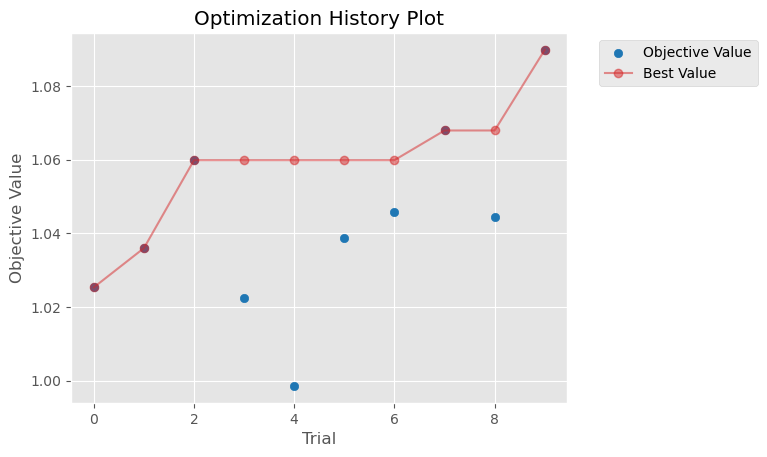

C:\Users\ste\AppData\Local\Temp\ipykernel_26796\3988646646.py:5: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  visualization.matplotlib.plot_param_importances(study)


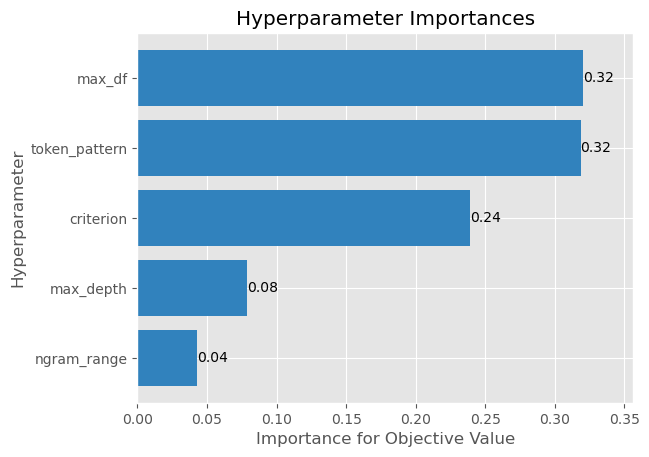

In [208]:
import matplotlib.pyplot as plt

visualization.matplotlib.plot_optimization_history(study)
plt.show()
visualization.matplotlib.plot_param_importances(study)
plt.show()

### Leave-One-Out Traning

In [215]:
import torch
from torch import nn
import numpy as np
from torchmetrics import (
    MetricCollection,
    Accuracy,
    AUROC,
    Precision,
    Recall,
    F1Score,
    # MeanAbsoluteError,
    # MeanSquaredError,
)
from torchmetrics.functional.classification import (
    accuracy,
    auroc,
    precision,
    recall,
    f1_score,
)

In [223]:
from sklearn.model_selection import LeaveOneOut

BALANCE_TRAIN_SET = True

features_col = "raw text"

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
report_table = []
predictions = []
targets = []

for k, (train_index, test_index) in enumerate(loo.split(dataset_df)):
    # Splitting the dataset
    train_df = dataset_df.iloc[train_index, :].copy()
    test_df = dataset_df.iloc[test_index, :].copy()
    # Train
    if BALANCE_TRAIN_SET:
        oversampled = balance_train_df(train_df, oversampling_dumping=0.9)
        train_df = pd.concat([
            train_df,
            oversampled.sample(400, random_state=42),
        ])
    X_train = np.array(train_df[features_col])
    y_train = np.array(train_df.iloc[:, 2:46])
    # Test
    X_test = np.array(test_df[features_col])
    y_test = np.array(test_df.iloc[:, 2:46])
    # Get pipeline
    pipeline = get_pipeline(**study.best_trial.params)
    # Fit the pipeline to your data
    pipeline.fit(X_train, y_train)
    # Evaluate the pipeline
    y_preds = torch.Tensor(np.array(pipeline.predict(X_test)))
    y_targets = torch.Tensor(y_test).to(torch.int32)
    # Metrics
    num_labels = y_train.shape[1]
    metrics = MetricCollection({
            'acc': Accuracy(task='multilabel', num_labels=num_labels), # Default: macro
            'roc_auc': AUROC(task='multilabel', num_labels=num_labels),
            'precision': Precision(task='multilabel', num_labels=num_labels),
            'recall': Recall(task='multilabel', num_labels=num_labels),
            'f1_score': F1Score(task='multilabel', num_labels=num_labels),
            'acc_weighted': Accuracy(task='multilabel', num_labels=num_labels, average='weighted'),
            'roc_auc_weighted': AUROC(task='multilabel', num_labels=num_labels, average='weighted'),
            'precision_weighted': Precision(task='multilabel', num_labels=num_labels, average='weighted'),
            'recall_weighted': Recall(task='multilabel', num_labels=num_labels, average='weighted'),
            'f1_score_weighted': F1Score(task='multilabel', num_labels=num_labels, average='weighted'),
        }, prefix='test_')
    # Suppress warning messages
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        metrics.update(y_preds, y_targets)
        results = {m: val.item() if isinstance(val, torch.Tensor) else val for m, val in metrics.compute().items()}
        results['k'] = k
    # Store predictions and labels for later processing
    predictions.append(y_preds)
    targets.append(y_targets)
    report_table.append(results)
    display(pd.DataFrame(report_table).round(3))
    print(f"K = {k} done.")

predictions = torch.vstack(predictions)
targets = torch.vstack(targets)
report_table = pd.DataFrame(report_table)
report_table

,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.6,0.375,0.375,0.375,0.0,0.0,0


K = 0 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1


K = 1 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2


K = 2 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3


K = 3 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4


K = 4 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5


K = 5 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6


K = 6 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7


K = 7 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8


K = 8 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 9 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 10 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 11 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 12 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 13 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 14 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 15 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 16 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 17 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 18 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 19 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 20 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 21 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 22 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 23 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 24 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 25 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 26 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 27 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 28 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 29 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 30 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 31 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 32 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 33 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 34 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 35 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 36 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 37 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 38 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 39 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 40 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 41 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 42 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 43 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 44 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 45 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 46 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 47 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 48 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 49 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 50 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 51 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 52 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 53 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 54 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 55 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 56 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 57 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 58 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
5,0.841,0.500,0.533,0.500,0.571,0.500,0.500,0.500,0.0,0.0,5
6,0.818,0.500,0.556,0.500,0.625,0.500,0.500,0.500,0.0,0.0,6
7,0.818,0.300,0.429,0.300,0.750,0.300,0.300,0.300,0.0,0.0,7
8,0.909,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,8
9,0.818,0.556,0.556,0.556,0.556,0.556,0.556,0.556,0.0,0.0,9


K = 59 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
56,0.750,0.333,0.353,0.333,0.375,0.333,0.333,0.333,0.0,0.0,56
57,0.773,0.571,0.444,0.571,0.364,0.571,0.571,0.571,0.0,0.0,57
58,0.864,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,58
59,0.795,0.571,0.471,0.571,0.400,0.571,0.571,0.571,0.0,0.0,59


K = 60 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
57,0.773,0.571,0.444,0.571,0.364,0.571,0.571,0.571,0.0,0.0,57
58,0.864,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,58
59,0.795,0.571,0.471,0.571,0.400,0.571,0.571,0.571,0.0,0.0,59
60,0.886,1.000,0.545,1.000,0.375,1.000,1.000,1.000,0.0,0.0,60


K = 61 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
58,0.864,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,58
59,0.795,0.571,0.471,0.571,0.400,0.571,0.571,0.571,0.0,0.0,59
60,0.886,1.000,0.545,1.000,0.375,1.000,1.000,1.000,0.0,0.0,60
61,0.841,0.545,0.632,0.545,0.750,0.545,0.545,0.545,0.0,0.0,61


K = 62 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
59,0.795,0.571,0.471,0.571,0.400,0.571,0.571,0.571,0.0,0.0,59
60,0.886,1.000,0.545,1.000,0.375,1.000,1.000,1.000,0.0,0.0,60
61,0.841,0.545,0.632,0.545,0.750,0.545,0.545,0.545,0.0,0.0,61
62,0.818,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,62


K = 63 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
60,0.886,1.000,0.545,1.000,0.375,1.000,1.000,1.000,0.0,0.0,60
61,0.841,0.545,0.632,0.545,0.750,0.545,0.545,0.545,0.0,0.0,61
62,0.818,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,62
63,0.841,0.667,0.696,0.667,0.727,0.667,0.667,0.667,0.0,0.0,63


K = 64 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
61,0.841,0.545,0.632,0.545,0.750,0.545,0.545,0.545,0.0,0.0,61
62,0.818,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,62
63,0.841,0.667,0.696,0.667,0.727,0.667,0.667,0.667,0.0,0.0,63
64,0.795,0.556,0.526,0.556,0.500,0.556,0.556,0.556,0.0,0.0,64


K = 65 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
62,0.818,0.667,0.667,0.667,0.667,0.667,0.667,0.667,0.0,0.0,62
63,0.841,0.667,0.696,0.667,0.727,0.667,0.667,0.667,0.0,0.0,63
64,0.795,0.556,0.526,0.556,0.500,0.556,0.556,0.556,0.0,0.0,64
65,0.705,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,65


K = 66 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
63,0.841,0.667,0.696,0.667,0.727,0.667,0.667,0.667,0.0,0.0,63
64,0.795,0.556,0.526,0.556,0.500,0.556,0.556,0.556,0.0,0.0,64
65,0.705,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,65
66,0.886,0.625,0.667,0.625,0.714,0.625,0.625,0.625,0.0,0.0,66


K = 67 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
64,0.795,0.556,0.526,0.556,0.500,0.556,0.556,0.556,0.0,0.0,64
65,0.705,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,65
66,0.886,0.625,0.667,0.625,0.714,0.625,0.625,0.625,0.0,0.0,66
67,0.682,0.333,0.300,0.333,0.273,0.333,0.333,0.333,0.0,0.0,67


K = 68 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
65,0.705,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,65
66,0.886,0.625,0.667,0.625,0.714,0.625,0.625,0.625,0.0,0.0,66
67,0.682,0.333,0.300,0.333,0.273,0.333,0.333,0.333,0.0,0.0,67
68,0.886,0.833,0.667,0.833,0.556,0.833,0.833,0.833,0.0,0.0,68


K = 69 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
66,0.886,0.625,0.667,0.625,0.714,0.625,0.625,0.625,0.0,0.0,66
67,0.682,0.333,0.300,0.333,0.273,0.333,0.333,0.333,0.0,0.0,67
68,0.886,0.833,0.667,0.833,0.556,0.833,0.833,0.833,0.0,0.0,68
69,0.795,0.455,0.526,0.455,0.625,0.455,0.455,0.455,0.0,0.0,69


K = 70 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
67,0.682,0.333,0.300,0.333,0.273,0.333,0.333,0.333,0.0,0.0,67
68,0.886,0.833,0.667,0.833,0.556,0.833,0.833,0.833,0.0,0.0,68
69,0.795,0.455,0.526,0.455,0.625,0.455,0.455,0.455,0.0,0.0,69
70,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,70


K = 71 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
68,0.886,0.833,0.667,0.833,0.556,0.833,0.833,0.833,0.0,0.0,68
69,0.795,0.455,0.526,0.455,0.625,0.455,0.455,0.455,0.0,0.0,69
70,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,70
71,0.818,0.714,0.556,0.714,0.455,0.714,0.714,0.714,0.0,0.0,71


K = 72 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
69,0.795,0.455,0.526,0.455,0.625,0.455,0.455,0.455,0.0,0.0,69
70,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,70
71,0.818,0.714,0.556,0.714,0.455,0.714,0.714,0.714,0.0,0.0,71
72,0.909,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.0,0.0,72


K = 73 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
70,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,70
71,0.818,0.714,0.556,0.714,0.455,0.714,0.714,0.714,0.0,0.0,71
72,0.909,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.0,0.0,72
73,0.841,0.600,0.462,0.600,0.375,0.600,0.600,0.600,0.0,0.0,73


K = 74 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
71,0.818,0.714,0.556,0.714,0.455,0.714,0.714,0.714,0.0,0.0,71
72,0.909,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.0,0.0,72
73,0.841,0.600,0.462,0.600,0.375,0.600,0.600,0.600,0.0,0.0,73
74,0.864,0.444,0.571,0.444,0.800,0.444,0.444,0.444,0.0,0.0,74


K = 75 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
72,0.909,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.0,0.0,72
73,0.841,0.600,0.462,0.600,0.375,0.600,0.600,0.600,0.0,0.0,73
74,0.864,0.444,0.571,0.444,0.800,0.444,0.444,0.444,0.0,0.0,74
75,0.795,0.400,0.471,0.400,0.571,0.400,0.400,0.400,0.0,0.0,75


K = 76 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
73,0.841,0.600,0.462,0.600,0.375,0.600,0.600,0.600,0.0,0.0,73
74,0.864,0.444,0.571,0.444,0.800,0.444,0.444,0.444,0.0,0.0,74
75,0.795,0.400,0.471,0.400,0.571,0.400,0.400,0.400,0.0,0.0,75
76,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,76


K = 77 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.841,0.375,0.462,0.375,0.600,0.375,0.375,0.375,0.0,0.0,0
1,0.886,0.750,0.545,0.750,0.429,0.750,0.750,0.750,0.0,0.0,1
2,0.795,0.500,0.400,0.500,0.333,0.500,0.500,0.500,0.0,0.0,2
3,0.795,0.429,0.400,0.429,0.375,0.429,0.429,0.429,0.0,0.0,3
4,0.886,0.571,0.615,0.571,0.667,0.571,0.571,0.571,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
74,0.864,0.444,0.571,0.444,0.800,0.444,0.444,0.444,0.0,0.0,74
75,0.795,0.400,0.471,0.400,0.571,0.400,0.400,0.400,0.0,0.0,75
76,0.818,0.444,0.500,0.444,0.571,0.444,0.444,0.444,0.0,0.0,76
77,0.886,0.333,0.286,0.333,0.250,0.333,0.333,0.333,0.0,0.0,77


K = 78 done.


,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
0,0.840909,0.375000,0.461538,0.375000,0.600000,0.375000,0.375000,0.375000,0.0,0.0,0
1,0.886364,0.750000,0.545455,0.750000,0.428571,0.750000,0.750000,0.750000,0.0,0.0,1
2,0.795455,0.500000,0.400000,0.500000,0.333333,0.500000,0.500000,0.500000,0.0,0.0,2
3,0.795455,0.428571,0.400000,0.428571,0.375000,0.428571,0.428571,0.428571,0.0,0.0,3
4,0.886364,0.571429,0.615385,0.571429,0.666667,0.571429,0.571429,0.571429,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
74,0.863636,0.444444,0.571429,0.444444,0.800000,0.444444,0.444444,0.444444,0.0,0.0,74
75,0.795455,0.400000,0.470588,0.400000,0.571429,0.400000,0.400000,0.400000,0.0,0.0,75
76,0.818182,0.444444,0.500000,0.444444,0.571429,0.444444,0.444444,0.444444,0.0,0.0,76
77,0.886364,0.333333,0.285714,0.333333,0.250000,0.333333,0.333333,0.333333,0.0,0.0,77


In [224]:
report_table.agg(['mean', 'std'])

,test_acc,test_acc_weighted,test_f1_score,test_f1_score_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc,test_roc_auc_weighted,k
mean,0.832278,0.528848,0.484574,0.528848,0.488738,0.528848,0.528848,0.528848,0.0,0.0,39.000000
std,0.055944,0.207799,0.162319,0.207799,0.190680,0.207799,0.207799,0.207799,0.0,0.0,22.949219


In [225]:
report_table.to_csv(f"../data/scores-nlp-decision_tree-loo.csv", index=False)
basedir = f"../data/processed/"
torch.save(predictions, f'{basedir}/nlp-decision_tree-loo-predictions.pt')
torch.save(targets, f'{basedir}/nlp-decision_tree-loo-targets.pt')

### Explainability And Tree Plotting

In [227]:
from sklearn.metrics import accuracy_score
import numpy as np

def tree_decision_path(pipeline, single_text, label='notte', path_as_string=True):
    # Transform the text to the tfidf representation
    tfidf_vector = pipeline.named_steps['tfidf'].transform([single_text])
    
    # Get the decision tree classifier
    if hasattr(pipeline.named_steps['clf'], 'estimators_'):
        decision_tree = pipeline.named_steps['clf'].estimators_[label2id[label]]
    else:
        decision_tree = pipeline.named_steps['clf']
    
    # Get the feature names
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    
    # Get the decision path in the tree for the tfidf vector
    node_indicator = decision_tree.decision_path(tfidf_vector)
    leaf_id = decision_tree.apply(tfidf_vector)
    
    # Output decision path
    feature_path = []
    for node_id in node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]:
        if leaf_id[0] == node_id:
            continue  # Skip leaf node

        # Check if value of the feature is greater than threshold
        if (tfidf_vector[0, decision_tree.tree_.feature[node_id]] > decision_tree.tree_.threshold[node_id]):
            threshold_sign = ">"
        else:
            threshold_sign = "<="

        # Append the feature and threshold
        if path_as_string:
            feat_in = feature_names[decision_tree.tree_.feature[node_id]]
            threshold = decision_tree.tree_.threshold[node_id]
            feature_path.append(f"{feat_in} {threshold_sign} {threshold:.4f}")
        else:
            feature_path.append((
                feature_names[decision_tree.tree_.feature[node_id]],
                threshold_sign,
                decision_tree.tree_.threshold[node_id]
            ))

    return feature_path

# Example usage
for i, row in dataset_df.sample(5, random_state=43).iterrows():
    # text_example = row['raw text']
    text_example = row['facts']
    y_true = row.iloc[2:46].tolist()
    y_pred = pipeline.predict([text_example])[0]

    print(row['facts'])
    # print([id2label[idx] for idx, label in enumerate(y_pred) if label == 1.0])
    # print([id2label[idx] for idx, label in enumerate(y_true) if label == 1.0])
    # Calculate accuracy
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

    for idx, (label_true, label_pred) in enumerate(zip(y_true, y_pred)):
        if label_true == 0 and label_pred == 0:
            continue
        label = id2label[idx]
        path = tree_decision_path(pipeline, text_example, label=label)
        print(f'\t* Path for label "{label}": {"" if label_true == label_pred else "(INCORRECT)"}')
        for step, node in enumerate(path):
            print(f"\t\t{step + 1}. {node}")
    print('-' * 80)

1. - Con sentenza resa in data 4.5.2012, la corte d'appello di Napoli, in totale riforma della sentenza diassoluzione (perchè il fatto non costituisce reato) emessa in data 2.11.2010 dal tribunale di Nola, hacondannato N.G., su impugnazione delle sole parti civili costituite, al risarcimento dei danni in favore diqueste ultime, in relazione al reato di omicidio colposo commesso, con violazione delle norme sulladisciplina della circolazione stradale, ai danni di B.C., in (OMISSIS).  Con la sentenza d'appello, la corte territoriale ha individuato la responsabilità del N. nella violazionedella norma di cui all'art. 142 C.d.S., avendo l'imputato proceduto, in occasione del sinistro oggetto digiudizio, a velocità eccessiva lungo la strada statale n. 268, ﬁnendo per collidere con l'autoveicolocondotto dalla persona offesa che, provenendo dall'opposto senso di marcia, aveva invaso la corsiapercorsa dall'autocarro dell'imputato, così provocando l'urto con quest'ultimo da cui erano derivate lel

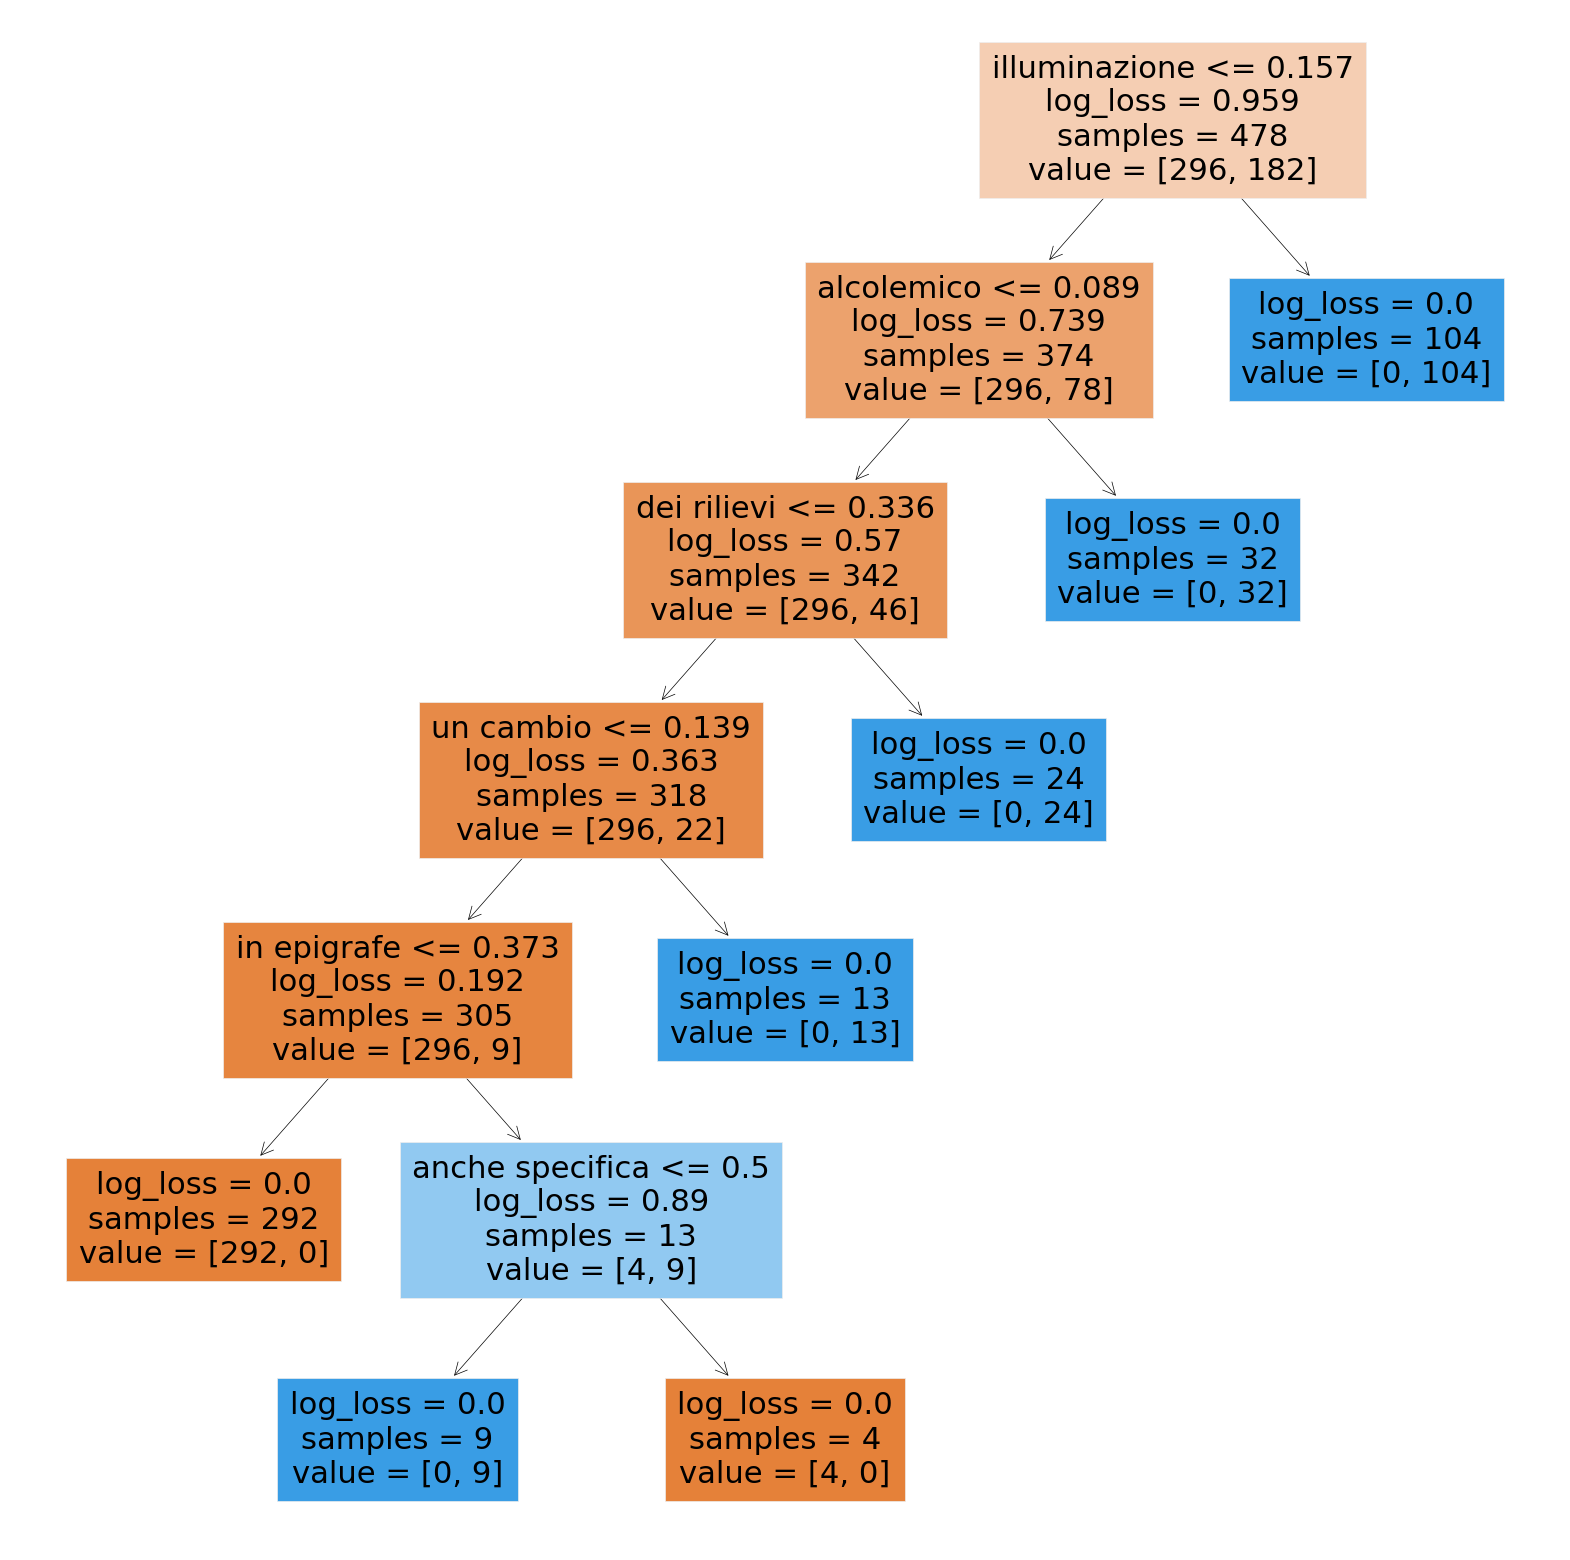

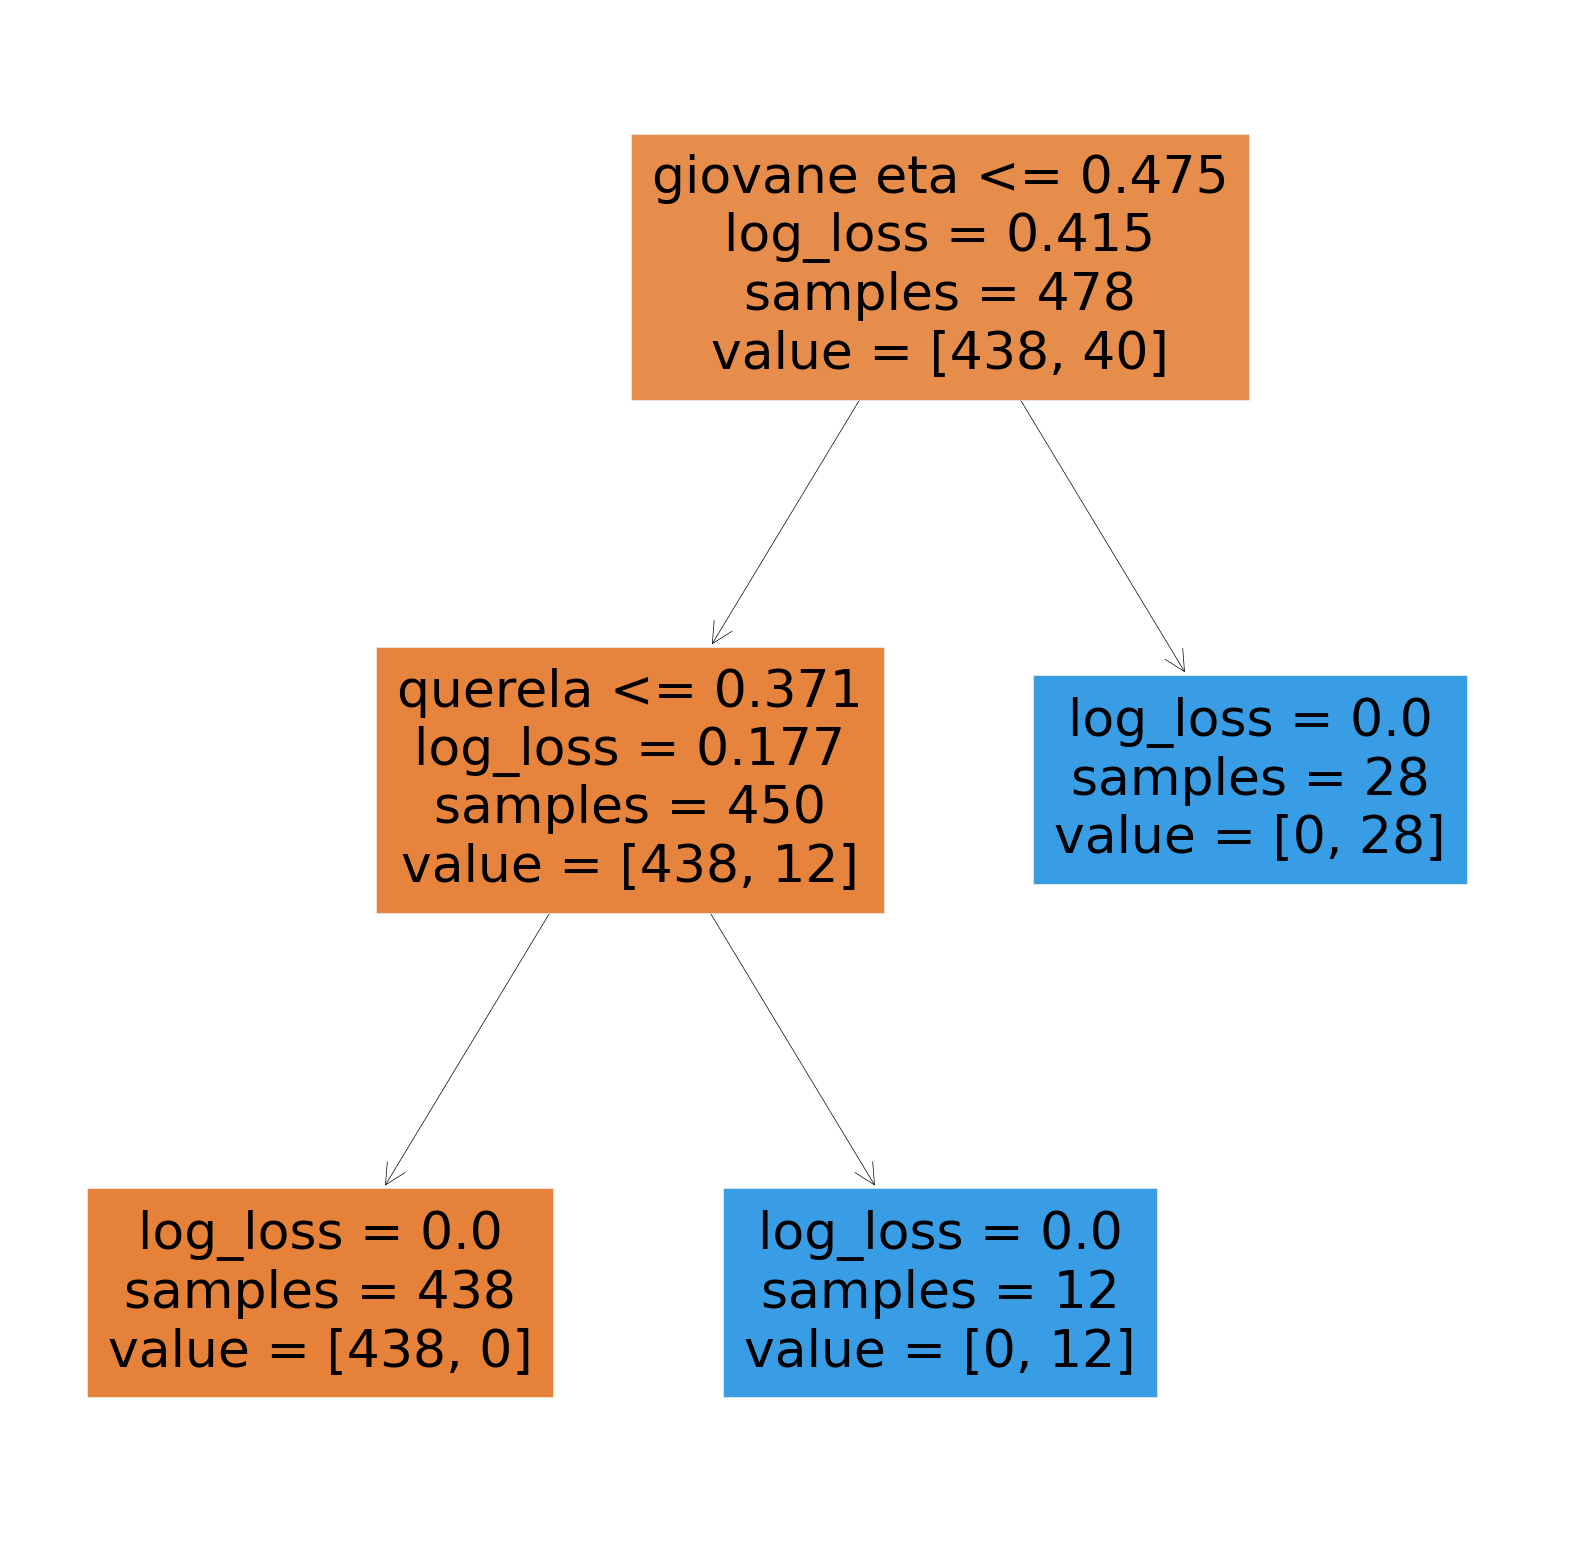

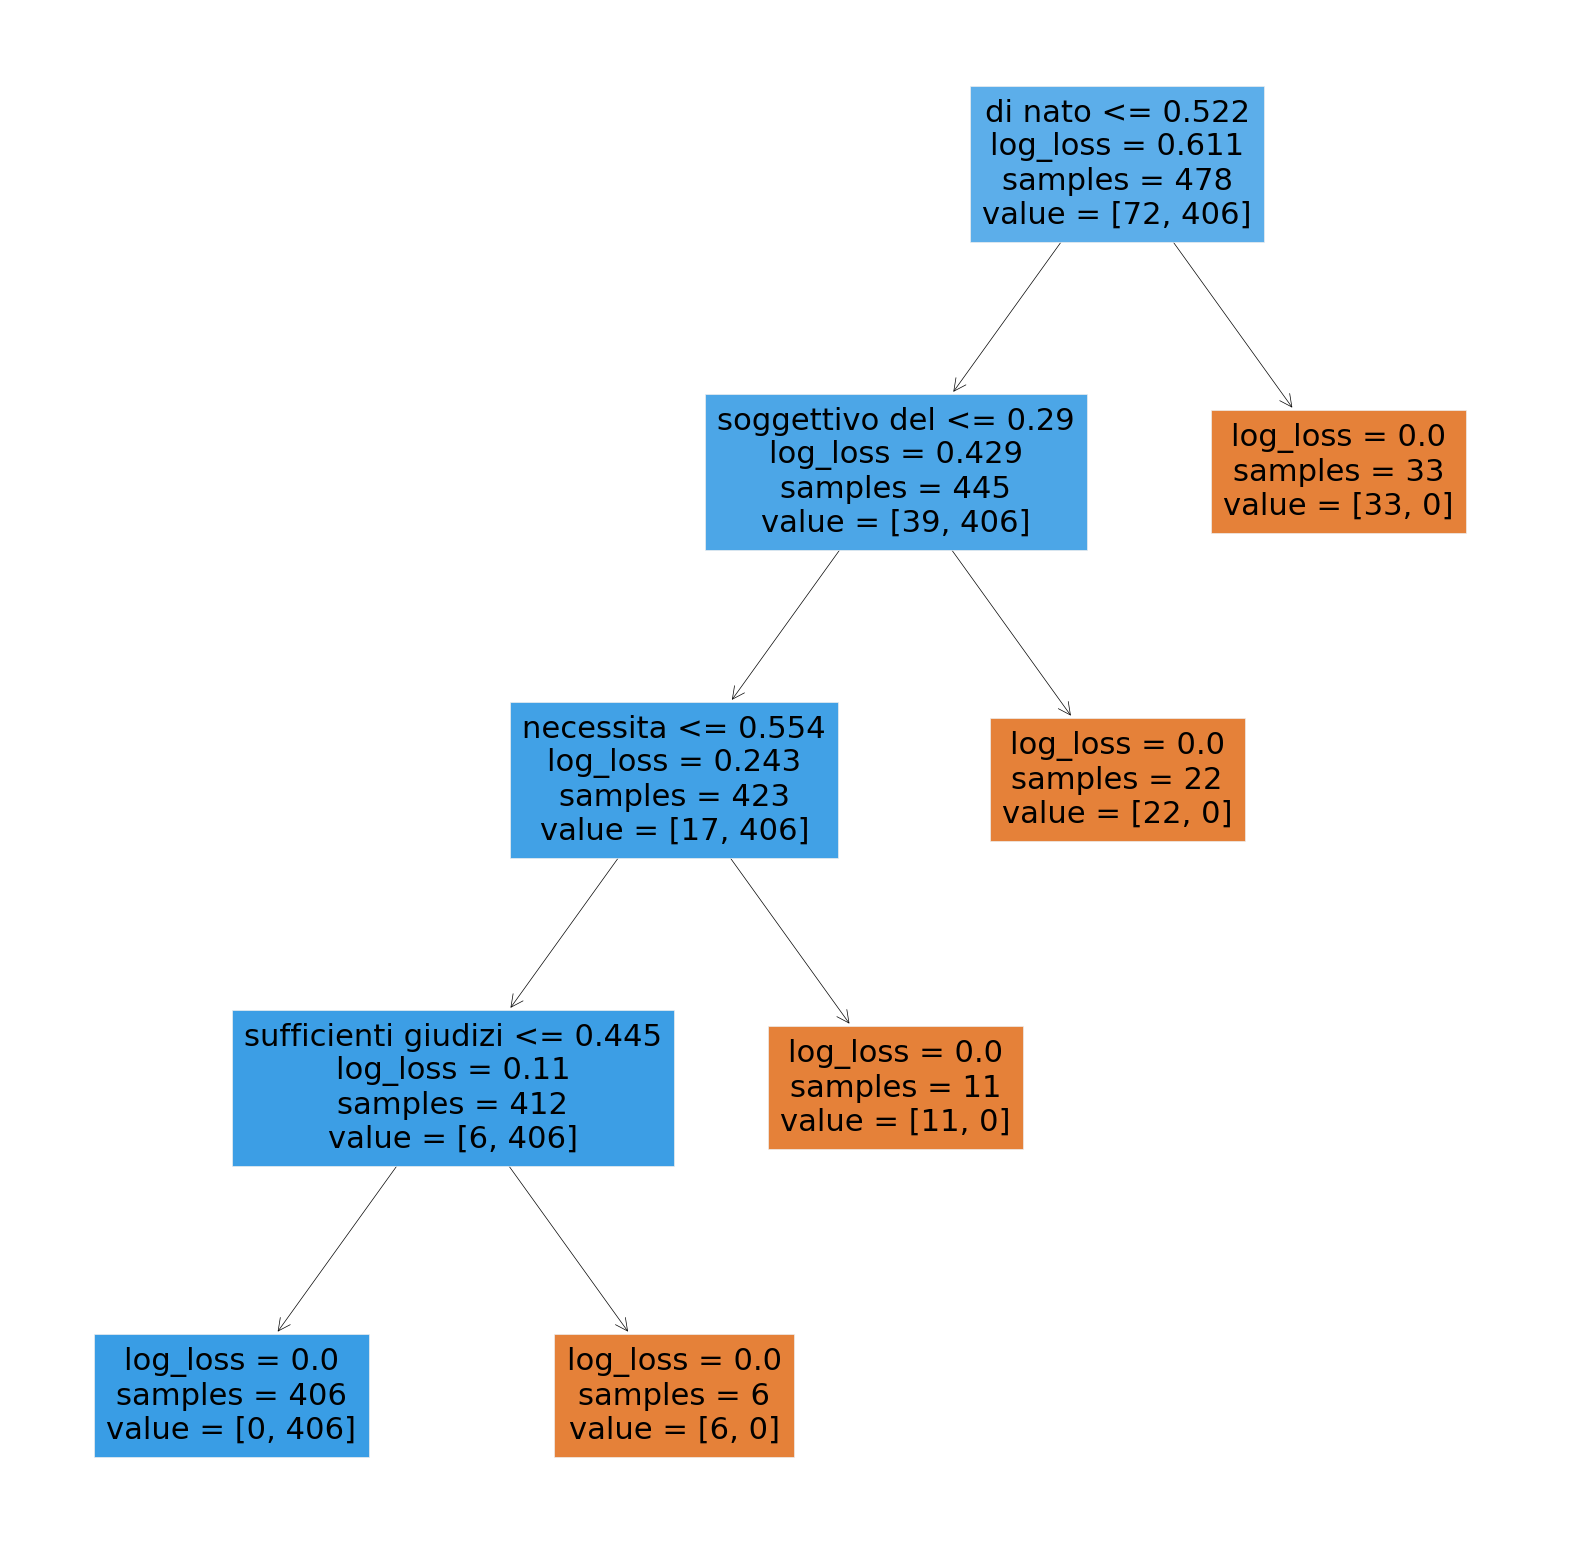

In [232]:
# Given a label, plot the corresponding decision tree in the pipeline
from sklearn import tree
import matplotlib.pyplot as plt
import re
import matplotlib

def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        # txt = re.sub("\nsamples[^$]*class", "\nclass", txt)
        txt = re.sub("\nvalue[^$]*", "", txt)
        obj.set_text(txt)
    return obj

def plot_decision_tree(pipeline, label='notte', plot_values=True):
    # Get the decision tree classifier
    # Get the decision tree classifier
    if hasattr(pipeline.named_steps['clf'], 'estimators_'):
        decision_tree = pipeline.named_steps['clf'].estimators_[label2id[label]]
    else:
        decision_tree = pipeline.named_steps['clf']

    # Get the feature names
    feature_names = list(pipeline.named_steps['tfidf'].get_feature_names_out())

    # Plot the tree
    with warnings.catch_warnings():
        # Suppress warning messages
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        fig, ax = plt.subplots(figsize=(20, 20))
        tree.plot_tree(decision_tree, feature_names=feature_names, filled=True, ax=ax,)
        if not plot_values:
            ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
        plt.savefig(f'../data/figures/decision_tree_{label}.pdf', bbox_inches='tight')
        fig.show()

plot_decision_tree(pipeline, label='notte')
plot_decision_tree(pipeline, label='giovane eta imputato')
plot_decision_tree(pipeline, label='violazione stop o semaforo o codice della strada da parte imputato')

## Plotting

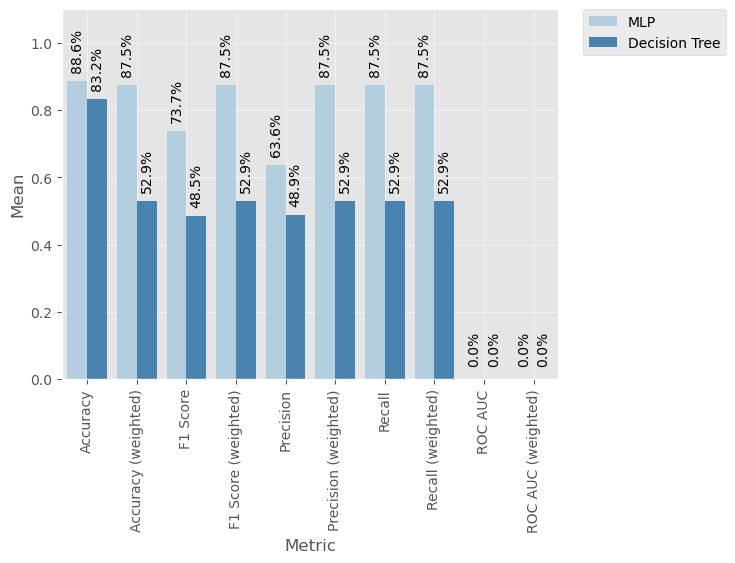

In [264]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mlp_report = pd.read_csv('../data/scores-nlp-count_vectorizer-loo.csv')
dt_report = pd.read_csv('../data/scores-nlp-decision_tree-loo.csv')
mlp_report = mlp_report.agg(['mean']).drop(columns=['test_loss', 'k']).T
dt_report = dt_report.agg(['mean']).drop(columns=['k']).T
mlp_report['Feature Extractor'] = 'MLP'
dt_report['Feature Extractor'] = 'Decision Tree'
report = pd.concat([mlp_report, dt_report])
# Rename index to 'Metric'
report = report.reset_index().rename(columns={'index': 'Metric', 'mean': 'Mean'})
# Map metric names to more readable names
report['Metric'] = report['Metric'].map({
    'test_acc': 'Accuracy',
    'test_acc_weighted': 'Accuracy (weighted)',
    'test_f1_score': 'F1 Score',
    'test_f1_score_weighted': 'F1 Score (weighted)',
    'test_precision': 'Precision',
    'test_precision_weighted': 'Precision (weighted)',
    'test_recall': 'Recall',
    'test_recall_weighted': 'Recall (weighted)',
    'test_roc_auc': 'ROC AUC',
    'test_roc_auc_weighted': 'ROC AUC (weighted)',
})
# Plot
sns.barplot(data=report, x='Metric', hue='Feature Extractor', y='Mean', palette='Blues')
plt.xticks(rotation=90)
# Put the legend outside of the plot on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Put values on top of bars, orient them vertically
for p in plt.gca().patches:
    plt.gca().annotate(
        f"{p.get_height():.1%}",
        (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        rotation=90,
    )
plt.ylim(0, 1.1)
plt.grid('y', alpha=0.5)
plt.show()

## Stratified K-Fold

Cannot work on multi-labels, skipping.

In [97]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import MultiLabelBinarizer

# # Data Preparation
# texts = dataset_df['raw text'] # dataset_df['facts']
# labels = dataset_df.iloc[:, 2:46]  # Adjust indices as needed
# full_dataset = TextDataset(texts, labels)

# mlb = MultiLabelBinarizer()
# mlb.fit(labels_columns)
# print(len(mlb.transform(labels)))

# skf = StratifiedKFold(n_splits=5)

# for k, (train_index, test_index) in enumerate(skf.split(texts.to_numpy(), mlb.transform(labels).T)):
#     # Splitting the dataset
#     train_subset = Subset(full_dataset, train_index)
#     test_subset = Subset(full_dataset, test_index)
#     # Creating data loaders for training and testing
#     train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
#     test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)
#     # Model Initialization
#     num_features = len(full_dataset.vectorizer.get_feature_names_out())
#     num_labels = labels.shape[1]
#     model = TextClassifier(num_features, num_labels)
#     # Trainer setup
#     trainer = pl.Trainer(
#         max_epochs=5,
#         enable_model_summary=False,
#         precision="32-true",
#     )
#     # Train the model
#     trainer.fit(model, train_loader)
#     # Evaluate the model on the test data
#     results = trainer.test(model, test_loader, verbose=False)[0]
#     results['k'] = k
#     report_table.append(results)
#     print(f"K = {k} done.")

# report_table = pd.DataFrame(report_table)
# report_table.to_csv(f"/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/scores-nlp-count_vectorizer-skf.csv", index=False)
# report_table

In [ ]:
# tmp = report_table.drop(columns=['test_hp_metric', 'k', 'test_opt_score']).describe().round(3)
# tmp.to_csv(f"/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/scores-nlp-count_vectorizer-skf-aggregated.csv")
# tmp